
### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
### Стоян Михов
### Зимен семестър 2025/2026

## Упражнение 9

За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
да се намира разархивиран в наддиректорията, в която е програмата (виж упражнение 2).

Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
conda activate tii

In [ ]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import TruncatedSVD

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            progress = self.item // self.period
            sys.stdout.write(f"\r[{'-'* progress}{' '*(self.barWidth - progress)}]")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("\r["+("-" * self.barWidth)+"]\n")

###  Разбиване на корпус на тестов и тренинг

In [3]:
def splitSentCorpus(fullSentCorpus, testFraction = 0.1):
    random.seed(42)
    random.shuffle(fullSentCorpus)
    testCount = int(len(fullSentCorpus) * testFraction)
    testSentCorpus = fullSentCorpus[:testCount]
    trainSentCorpus = fullSentCorpus[testCount:]
    return testSentCorpus, trainSentCorpus

####   Мултиномен Бейсов класификатор от упражнение 4

In [4]:
def trainMultinomialNB(trainClassCorpus):
    N = sum(len(classList) for classList in trainClassCorpus)
    classesCount = len(trainClassCorpus)
    pb = progressBar(50)
    pb.start(N)
    V = {}
    for c in range(classesCount):
        for text in trainClassCorpus[c]:
            pb.tick()
            terms = [ token.lower() for token in text if token.isalpha() ]
            for term in terms:
                if term not in V:
                    V[term] = [0] * classesCount
                V[term][c] += 1
    pb.stop()

    Nc = [ (len(classList)) for classList in trainClassCorpus ]
    prior = [ Nc[c] / N for c in range(classesCount) ]
    T = [0] * classesCount
    for t in V:
        for c in range(classesCount):
            T[c] += V[t][c]
    condProb = {}
    for t in V:
        condProb[t] = [ (V[t][c] +1) / (T[c] + len(V)) for c in range(classesCount)]
    return condProb, prior, V

def applyMultinomialNB(prior, condProb, text, features = None ):
    terms = [ token.lower() for token in text if token.isalpha() ]
    for c in range(len(prior)):
        score = math.log(prior[c])
        for t in terms:
            if t not in condProb: continue
            if features and t not in features: continue
            score += math.log(condProb[t][c])
        if c == 0 or score > maxScore:
            maxScore = score
            answer = c
    return answer

def testClassifier(testClassCorpus, gamma):
    L = [ len(c) for c in testClassCorpus ]
    pb = progressBar(50)
    pb.start(sum(L))
    classesCount = len(testClassCorpus)
    confusionMatrix = [ [0] * classesCount for _ in range(classesCount) ]
    for c in range(classesCount):
        for text in testClassCorpus[c]:
            pb.tick()
            c_MAP = gamma(text)
            confusionMatrix[c][c_MAP] += 1
    pb.stop()
    precision = []
    recall = []
    Fscore = []
    for c in range(classesCount):
        extracted = sum(confusionMatrix[x][c] for x in range(classesCount))
        if confusionMatrix[c][c] == 0:
            precision.append(0.0)
            recall.append(0.0)
            Fscore.append(0.0)
        else:
            precision.append( confusionMatrix[c][c] / extracted )
            recall.append( confusionMatrix[c][c] / L[c] )
            Fscore.append((2.0 * precision[c] * recall[c]) / (precision[c] + recall[c]))
    P = sum( L[c] * precision[c] / sum(L) for c in range(classesCount) )
    R = sum( L[c] * recall[c] / sum(L) for c in range(classesCount) )
    F1 = (2*P*R) / (P + R)
    print('=================================================================')
    print('Матрица на обърквания: ')
    for row in confusionMatrix:
        for val in row:
            print('{:4}'.format(val), end = '')
        print()
    print('Прецизност: '+str(precision))
    print('Обхват: '+str(recall))
    print('F-оценка: '+str(Fscore))
    print('Обща презизност: '+str(P))
    print('Общ обхват: '+str(R))
    print('Обща F-оценка: '+str(F1))
    print('=================================================================')
    print()

####   Влагане на думи в нискомерно гъсто векторно пространство от упражнение 6

In [5]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
        dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    return words, word2ind


def co_occurrence_matrix(corpus, window_size=4, limit=20000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    X=np.zeros((num_words,num_words))
    pb = progressBar()
    pb.start(len(corpus))
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    pb.stop()
    return X, words, word2ind

def PMI_matrix(C):
    rowSums = np.sum(C,axis=1)
    colSums = np.sum(C,axis=0)
    D = np.sum(rowSums)
    Z = np.outer(rowSums,colSums)
    X = np.maximum(np.log( D * C / Z),0)
    return X

def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced


###  Влагане на документи в нискомерно гъсто векторно пространство


In [6]:
def docVector(document, Embedding, word2ind):
    tf = np.zeros(len(word2ind))
    for w in document:
        if w in word2ind:
            tf[word2ind[w]] += 1
    d=np.dot(tf,Embedding)
    return d / np.linalg.norm(d)

def corpusEmbedding(corpus, Embedding, word2ind):
    return np.stack([ docVector(doc, Embedding, word2ind) for doc in corpus ])

####    Логистична регресия -- Бинарен класификатор


In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def crossEntropyS(X, Y, w, b):
	# X.shape = (S,N) Y.shape = (S), W.shape = (N) 
    v = sigmoid(np.dot(X,w)+b)
    p = (1-Y) + (2*Y-1)*v
    ce = -np.mean(np.log(p))
    return ce

def gradCrossEntropyS(X,Y,w,b):
    g = Y - sigmoid(np.dot(X,w)+b)
    db = -np.mean(g)
    dw = -np.mean( g[:,np.newaxis] * X,axis=0)
    return dw, db


In [8]:
####    Логистична регресия -- класификатор при много класове


In [9]:
def softmaxV(u):
    ### u следва да бъде вектор с резмер N
    e = np.exp(u)
    return e / np.sum(e)

def softmaxM(U):
    ### U следва да бъде матрица с размерност: (S,N)
    e = np.exp(U)
    return e / np.sum(e,axis=1)[:,np.newaxis]

def crossEntropyM(X, Y, W, b):
    ### класовете са k
    ### X е с размерност: (S,N)
    ### Y е с размерност: (S)
    ### W е с размерност: (N,K)
    ### b е с размерност: (K)

    S = X.shape[0]
    v = softmaxM(np.dot(X,W)+b[np.newaxis,:])
    p = v[np.arange(S),Y]
    ce = -np.mean(np.log(p))
    return ce

def gradCrossEntropyM(X,Y,W,b):
    S = X.shape[0]
    v = softmaxM(np.dot(X,W)+b[np.newaxis,:])
    v = -v
    v[np.arange(S),Y] += 1.
    db = -np.mean(v, axis=0)
    dW = -(1/S) * np.dot(X.transpose(), v)
    return dW, db


####    спускане по градиента


In [10]:
def gradientDescend(X,Y,tX,tY,w0,b0,crossEntropy,gradCrossEntropy,alpha=1.):
    epoch=0
    w=w0
    b=b0
    ceList = []
    tceList = []
    while epoch<100000:
        if epoch % 1000 == 0:
            ce = crossEntropy(X, Y, w, b)
            tce = crossEntropy(tX, tY, w, b)
            print(epoch,ce,tce)
            ceList.append(ce)
            tceList.append(tce)
        epoch += 1
        dw, db = gradCrossEntropy(X,Y,w,b)
        b -= alpha * db
        w -= alpha * dw
    return w,b,ceList,tceList


#####   Зареждане на корпуса

In [11]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
fileNames = myCorpus.fileids()

ecoCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('E-Economy'+'/')==0 ]
milCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('S-Military'+'/')==0 ]
polCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('J-Politics'+'/')==0 ]
culCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('C-Culture'+'/')==0 ]
socCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('D-Society'+'/')==0 ]
zCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('Z'+'/')==0 ]

testEcoCorpus, trainEcoCorpus = splitSentCorpus(ecoCorpus)
testMilCorpus, trainMilCorpus = splitSentCorpus(milCorpus)
testPolCorpus, trainPolCorpus = splitSentCorpus(polCorpus)
testCulCorpus, trainCulCorpus = splitSentCorpus(culCorpus)



<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Rumen\AppData\Local\Temp\ipykernel_18580\1111099134.py:2: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


#####   Тестване на Бейсов класификатор

In [12]:

condProbM, priorM, VM = trainMultinomialNB([trainEcoCorpus,trainMilCorpus,trainPolCorpus,trainCulCorpus])

gamma = lambda text : applyMultinomialNB(priorM, condProbM, text)
testClassifier([testEcoCorpus,testMilCorpus,testPolCorpus,testCulCorpus], gamma)

condProbM, priorM, VM = trainMultinomialNB([trainEcoCorpus,trainMilCorpus])

gamma = lambda text : applyMultinomialNB(priorM, condProbM, text)
testClassifier([testEcoCorpus,testMilCorpus], gamma)


[--------------------------------------------------]
[--------------------------------------------------]
Матрица на обърквания: 
  45   0  20   0
   2 127  28   1
  10  36 688   1
   1   0   2  42
Прецизност: [0.7758620689655172, 0.7791411042944786, 0.9322493224932249, 0.9545454545454546]
Обхват: [0.6923076923076923, 0.8037974683544303, 0.9360544217687075, 0.9333333333333333]
F-оценка: [0.7317073170731708, 0.7912772585669782, 0.9341479972844534, 0.9438202247191012]
Обща презизност: 0.8989961380342492
Общ обхват: 0.8993020937188435
Обща F-оценка: 0.8991490898494726

[--------------------------------------------------]
[--------------------------------------------------]----]
Матрица на обърквания: 
  60   5
   5 153
Прецизност: [0.9230769230769231, 0.9683544303797469]
Обхват: [0.9230769230769231, 0.9683544303797469]
F-оценка: [0.9230769230769231, 0.9683544303797469]
Обща презизност: 0.9551569506726457
Общ обхват: 0.9551569506726457
Обща F-оценка: 0.9551569506726457



###  Влагане на думите

In [13]:
C, words, word2ind = co_occurrence_matrix(ecoCorpus+milCorpus+polCorpus+culCorpus+socCorpus+zCorpus)
X = PMI_matrix(C)
X_reduced = SVD_k_dim(X)

X_lengths_100d = np.linalg.norm(X_reduced, axis=1)
X_normalized_100d = X_reduced / X_lengths_100d[:, np.newaxis]


[--------------------------------------------------]
[--------------------------------------------------]


C:\Users\Rumen\AppData\Local\Temp\ipykernel_18580\2891412210.py:44: RuntimeWarning: divide by zero encountered in log
  X = np.maximum(np.log( D * C / Z),0)


Running Truncated SVD over 20000 words...
Done.


In [14]:
testClassifier([testEcoCorpus,testMilCorpus], gamma)

[--------------------------------------------------]----]
Матрица на обърквания: 
  60   5
   5 153
Прецизност: [0.9230769230769231, 0.9683544303797469]
Обхват: [0.9230769230769231, 0.9683544303797469]
F-оценка: [0.9230769230769231, 0.9683544303797469]
Обща презизност: 0.9551569506726457
Общ обхват: 0.9551569506726457
Обща F-оценка: 0.9551569506726457



0 1.3901413524794382 1.4011360895321865
1000 0.4649768498017681 0.4756690448428008
2000 0.3833587524198124 0.39348892234674915
3000 0.34411613898621013 0.3545695614048132
4000 0.3199767134250455 0.3313897825779903
5000 0.30316867108374673 0.31584698577207776
6000 0.29057015048530216 0.3046205249633559
7000 0.28065939135748036 0.29608356106026745
8000 0.2725937872042222 0.2893413024523509
9000 0.2658624729922241 0.2838592514627351
10000 0.2601341576758092 0.2792976643357455
11000 0.25518270602272775 0.2754298675817083
12000 0.2508474716739653 0.27209863861448114
13000 0.2470106396463101 0.26919139983179247
14000 0.2435835353122102 0.26662536945868137
15000 0.24049796049721742 0.2643382865067469
16000 0.23770049724494344 0.26228240625058663
17000 0.23514864110723843 0.2604204923592349
18000 0.23280810439451693 0.25872307014514206
19000 0.23065089130135535 0.25716650014789266
20000 0.2286538960977859 0.2557315992487718
21000 0.226797864110631 0.2544026356396182
22000 0.22506660950286383 0

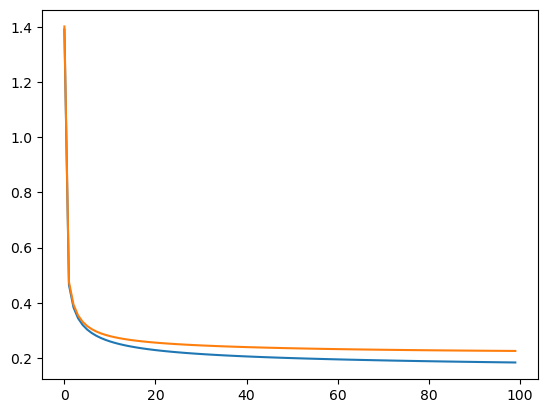

In [15]:
trainX = np.concatenate((
                         corpusEmbedding(trainEcoCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(trainMilCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(trainPolCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(trainCulCorpus,X_normalized_100d,word2ind)
                         ))
trainY = np.concatenate((
                         np.ones(len(trainEcoCorpus),dtype='int32')*0,
                         np.ones(len(trainMilCorpus),dtype='int32')*1,
                         np.ones(len(trainPolCorpus),dtype='int32')*2,
                         np.ones(len(trainCulCorpus),dtype='int32')*3
                         ))

testX = np.concatenate((
                         corpusEmbedding(testEcoCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(testMilCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(testPolCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(testCulCorpus,X_normalized_100d,word2ind)
                         ))
testY = np.concatenate((
                         np.ones(len(testEcoCorpus),dtype='int32')*0,
                         np.ones(len(testMilCorpus),dtype='int32')*1,
                         np.ones(len(testPolCorpus),dtype='int32')*2,
                         np.ones(len(testCulCorpus),dtype='int32')*3
                         ))

W0 = np.random.normal(0.,1.,size=(100,4))
b0 = np.random.normal(0., 1., 4)

W,b,ceList,tceList = gradientDescend(trainX,trainY,testX,testY,np.copy(W0),np.copy(b0),crossEntropyM,gradCrossEntropyM,alpha=1.)

plt.plot([*range(len(ceList))],ceList)
plt.plot([*range(len(tceList))],tceList)
plt.show()


In [16]:
gamma = lambda text : np.argmax(softmaxV(np.dot(docVector(text, X_normalized_100d, word2ind),W)+b))
testClassifier([testEcoCorpus,testMilCorpus,testPolCorpus,testCulCorpus], gamma)


[--------------------------------------------------]
Матрица на обърквания: 
  51   0  13   1
   1 132  24   1
   6  23 704   2
   1   0   2  42
Прецизност: [0.864406779661017, 0.8516129032258064, 0.9475100942126514, 0.9130434782608695]
Обхват: [0.7846153846153846, 0.8354430379746836, 0.9578231292517007, 0.9333333333333333]
F-оценка: [0.8225806451612904, 0.8434504792332268, 0.952638700947226, 0.9230769230769231]
Обща презизност: 0.9254717399358738
Общ обхват: 0.9262213359920239
Обща F-оценка: 0.9258463862394933



### Упражнение 9

Обектна имплементация на Backpropagation с Numpy операции

Първи вариант

In [17]:
class compNode:
    ################################################################################
    #### Базов обект за връх в изчислителния граф -- първи вариант
    ################################################################################

    def __init__(self, predecessors, trainable = True):
        self.predecessors = predecessors
        self.trainable = trainable
        self.value = None
        self.grad = None

    def calcValue(self): ## трябва да се дефинира за конкретния връх като се извика setValue
        return

    def propagateGrad(self, grad):
        if not self.grad:
            self.grad = grad
        else:
            self.grad += grad

    def derivative(self,i): ## трябва да се дефинира за конкретния връх
        return
    
    def propagateBack(self):
        if not self.predecessors: return
        for i,p in enumerate(self.predecessors):
            if p.trainable:
                partialGrad = np.dot(self.grad,self.derivative(i))
                p.propagateGrad(partialGrad)

Конкретни инстанции на обекти за върхове в изчислителния граф 

In [18]:
class logNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        self.value = np.log(x)
    def derivative(self,i):
        x = self.predecessors[0].value
        return np.diag(1/x)

class sigmoidNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        self.value = sigmoid(x)
    def derivative(self,i):
        t = self.predecessors[0].value
        s = sigmoid(t)
        return np.diag(s*(1-s))

class minusMeanNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        self.value = -np.mean(x)
    def derivative(self,i):
        x = self.predecessors[0].value
        S=x.shape[0]
        return -1/S * np.ones(S)

class probNode(compNode):
    def calcValue(self):
        v = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = (1-y) + (2*y-1)*v
    def derivative(self,i):
        assert i==0
        y = self.predecessors[1].value
        return np.diag(2*y-1)

class plusVectorsNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = x+y
    def derivative(self,i):
        S = self.value.shape[0]
        return np.eye(S)

class mulMatrixVectorNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = np.dot(x,y)
    def derivative(self,i):
        assert i==1
        u = self.predecessors[0].value
        return u

class copyNode(compNode):
    def calcValue(self):
        self.value = self.predecessors[0].value
    def derivative(self,i):
        S = self.grad.shape
        return np.ones(S)

Създаване на изчислителен граф за логистичната регресия -- първи вариант

In [19]:
x = compNode(None,trainable=False)
y = compNode(None,trainable=False)
w = compNode(None)
b = compNode(None)
u = mulMatrixVectorNode([x,w])
bS = copyNode([b])
t = plusVectorsNode([u,bS])
v = sigmoidNode([t])
p = probNode([v,y])
l = logNode([p])
h = minusMeanNode([l])

Топологично сортиране на върховете на изчислителен граф

In [20]:
def getSortedNodes(t,L):
    if t in L: return L
    if t.predecessors:
        for p in t.predecessors:
            L = getSortedNodes(p,L)
    L.append(t)
    return L


Базов обект за модел на невронна мрежа

Съдържа имплементация на Backpropagation

и стохастично спускане по градиента

In [21]:
class model:
    def __init__(self, topNode):
        self.topNode = topNode
        self.sortedNodes = getSortedNodes(topNode,[])
        self.paramNodes = [ v for v in self.sortedNodes if v.trainable and not v.predecessors ]
        self.dataNodes = [ v for v in self.sortedNodes if not v.trainable and not v.predecessors ]

    def setParameters(self, params):
        for i, p in enumerate(params):
            self.paramNodes[i].value = np.copy(p)

    def setData(self, data):
        for i, d in enumerate(data):
            self.dataNodes[i].value = d
    
    def forward(self):
        for v in self.sortedNodes:
            v.calcValue()

    def backwards(self):
        for v in self.sortedNodes:
            v.grad = None
        self.topNode.propagateGrad(1)
        for v in reversed(self.sortedNodes):
            v.propagateBack()

    def updateModel(self,alpha):
        for p in self.paramNodes:
            p.value -= alpha * p.grad

    def calcLoss(self,testData):
        self.setData(testData)
        self.forward()
        return self.topNode.value

    def batchedStochasticGradient(self, initialParams, trainData, testData, batchSize, alpha = 1., maxStep = 100000, printInterval = 1000):
        self.setParameters(initialParams)
        self.topNode.value = None
        ceList = []
        tceList = []
        epoch = 0
        step = 0
        samples = np.arange(trainData[0].shape[0], dtype='int32')
        while True:
            np.random.shuffle(samples)
            for i in range(0,len(samples),batchSize):
                if step % printInterval == 0:
                    ce = self.topNode.value
                    tce = self.calcLoss(testData)
                    print("Epoch: ",epoch, ", step: ",step, ", train loss: ", ce, ", test loss: ",tce)
                    ceList.append(ce)
                    tceList.append(tce)
                idx = samples[i:min(i+batchSize, len(samples))]
                batchData = [d[idx] for d in trainData ]
                self.setData(batchData)
                self.forward()
                self.backwards()
                self.updateModel(alpha)
                step += 1

                    
                if step >= maxStep: return ceList, tceList
            epoch += 1
        

In [22]:
x = compNode(None,trainable=False)
y = compNode(None,trainable=False)
w = compNode(None)
b = compNode(None)
u = mulMatrixVectorNode([x,w])
bS = copyNode([b])
t = plusVectorsNode([u,bS])
v = sigmoidNode([t])
p = probNode([v,y])
l = logNode([p])
h = minusMeanNode([l])
logistic = model(h)

Epoch:  0 , step:  0 , train loss:  None , test loss:  1.4377669906382167
Epoch:  10 , step:  10 , train loss:  0.562404039460713 , test loss:  0.560197990072616
Epoch:  20 , step:  20 , train loss:  0.5474942031673484 , test loss:  0.5462940529534209
Epoch:  30 , step:  30 , train loss:  0.5336081508173457 , test loss:  0.5333783543488309
Epoch:  40 , step:  40 , train loss:  0.5206293378786021 , test loss:  0.5213016300644494
Epoch:  50 , step:  50 , train loss:  0.5084908140080819 , test loss:  0.5100005703765378
Epoch:  60 , step:  60 , train loss:  0.4971293173204371 , test loss:  0.49941599598254954
Epoch:  70 , step:  70 , train loss:  0.4864854666795172 , test loss:  0.4894925463231892
Epoch:  80 , step:  80 , train loss:  0.47650383445795386 , test loss:  0.4801786973631408
Epoch:  90 , step:  90 , train loss:  0.4671329246672317 , test loss:  0.47142670183791413
Epoch:  100 , step:  100 , train loss:  0.4583250789345215 , test loss:  0.46319246935713937
Epoch:  110 , step:  1

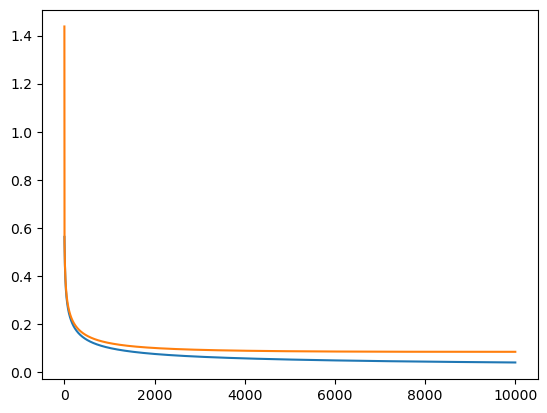

In [23]:

trainX = np.concatenate((
                         corpusEmbedding(trainEcoCorpus,X_normalized_100d,word2ind),
                         corpusEmbedding(trainMilCorpus,X_normalized_100d,word2ind)
                         ))
trainY = np.concatenate((
                         np.ones(len(trainEcoCorpus),dtype='int32')*0,
                         np.ones(len(trainMilCorpus),dtype='int32')*1
                         ))
testX = np.concatenate((
                        corpusEmbedding(testEcoCorpus,X_normalized_100d,word2ind),
                        corpusEmbedding(testMilCorpus,X_normalized_100d,word2ind)
                        ))
testY = np.concatenate((
                        np.ones(len(testEcoCorpus),dtype='int32')*0,
                        np.ones(len(testMilCorpus),dtype='int32')*1
                        ))

w0 = np.random.normal(0.,1.,100)
b0 = np.random.normal(0., 1., 1)

ceList,tceList = logistic.batchedStochasticGradient([np.copy(w0),np.copy(b0)], [trainX,trainY], [testX,testY], trainX.shape[0], maxStep = 100000, printInterval = 10)
w1 = np.copy(w.value)
b1 = np.copy(b.value)
plt.plot([*range(len(ceList))],ceList)
plt.plot([*range(len(tceList))],tceList)
plt.show()

gamma = lambda text : 1 if sigmoid(np.dot(w1,docVector(text, X_normalized_100d, word2ind))+b1)>0.5 else 0

In [24]:
testClassifier([testEcoCorpus,testMilCorpus], gamma)

[--------------------------------------------------]----]
Матрица на обърквания: 
  65   0
   4 154
Прецизност: [0.9420289855072463, 1.0]
Обхват: [1.0, 0.9746835443037974]
F-оценка: [0.9701492537313433, 0.9871794871794872]
Обща презизност: 0.9831026190940404
Общ обхват: 0.9820627802690582
Обща F-оценка: 0.9825824245737181



### Втори, подобрен вариант

In [25]:
class compNode:
    def __init__(self, predecessors, trainable = True):
        self.predecessors = predecessors
        self.trainable = trainable
        self.value = None
        self.grad = None
    
    def calcValue(self): ## трябва да се дефинира за конкретния връх като се извика setValue
        return
    
    def propagateGrad(self, grad):
        if not self.grad:
            self.grad = grad
        else:
            self.grad += grad

    def derivativeMult(self,i): ## трябва да се дефинира за конкретния връх
        return
    
    def propagateBack(self):
        if not self.predecessors: return
        for i,p in enumerate(self.predecessors):
            if p.trainable:
                partialGrad = self.derivativeMult(i)
                p.propagateGrad(partialGrad)

In [26]:
class crossEntropyNode(compNode):
    def calcValue(self):
        t = self.predecessors[0].value
        y = self.predecessors[1].value
        self.v = sigmoid(t)
        p = (1-y) + (2*y-1) * self.v
        self.value = -np.mean(np.log(p))
    def derivativeMult(self,i):
        y = self.predecessors[1].value
        S = y.shape[0]
        return self.grad * (-(y-self.v)/S)

class plusVectorsNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = x+y
    def derivativeMult(self,i):
        return self.grad

class mulMatrixVectorNode(compNode):
    def calcValue(self):
        x = self.predecessors[0].value
        y = self.predecessors[1].value
        self.value = np.dot(x,y)
    def derivativeMult(self,i):
        assert i==1
        x = self.predecessors[0].value
        return np.dot(self.grad,x)

class copyNode(compNode):
    def calcValue(self):
        self.value = self.predecessors[0].value
    def derivativeMult(self,i):
        return np.sum(self.grad)

In [27]:
x = compNode(None,trainable=False)
y = compNode(None,trainable=False)
w = compNode(None)
b = compNode(None)
u = mulMatrixVectorNode([x,w])
bS = copyNode([b])
t = plusVectorsNode([u,bS])
h = crossEntropyNode([t,y])

logisticBetter = model(h)

In [28]:
cefList, tcefList = logisticBetter.batchedStochasticGradient([np.copy(w0),np.copy(b0)], [trainX,trainY], [testX,testY], trainX.shape[0], maxStep = 100000, printInterval = 1000)
w1 = np.copy(w.value)
b1 = np.copy(b.value)
gamma = lambda text : 1 if sigmoid(np.dot(w1,docVector(text, X_normalized_100d, word2ind))+b1)>0.5 else 0
testClassifier([testEcoCorpus,testMilCorpus], gamma)

Epoch:  0 , step:  0 , train loss:  None , test loss:  1.4377669906382167
Epoch:  1000 , step:  1000 , train loss:  0.245556567300468 , test loss:  0.25877217781556927
Epoch:  2000 , step:  2000 , train loss:  0.19236957282423572 , test loss:  0.2068752716480684
Epoch:  3000 , step:  3000 , train loss:  0.16457307306947094 , test loss:  0.1802326976483899
Epoch:  4000 , step:  4000 , train loss:  0.146653273963851 , test loss:  0.16322318158521096
Epoch:  5000 , step:  5000 , train loss:  0.13385297587511988 , test loss:  0.15116359857612985
Epoch:  6000 , step:  6000 , train loss:  0.12411826666532255 , test loss:  0.142070709363387
Epoch:  7000 , step:  7000 , train loss:  0.11639273950502284 , test loss:  0.13493083581831716
Epoch:  8000 , step:  8000 , train loss:  0.11006881352653793 , test loss:  0.12915964352277493
Epoch:  9000 , step:  9000 , train loss:  0.10476855212772533 , test loss:  0.12439136997167316
Epoch:  10000 , step:  10000 , train loss:  0.10024276061564921 , test

In [29]:
cebList, tcebList = logisticBetter.batchedStochasticGradient([np.copy(w0),np.copy(b0)], [trainX,trainY], [testX,testY], 100, maxStep = 100000, printInterval = 1000)
w1 = np.copy(w.value)
b1 = np.copy(b.value)
gamma = lambda text : 1 if sigmoid(np.dot(w1,docVector(text, X_normalized_100d, word2ind))+b1)>0.5 else 0
testClassifier([testEcoCorpus,testMilCorpus], gamma)

Epoch:  0 , step:  0 , train loss:  None , test loss:  1.4377669906382167
Epoch:  47 , step:  1000 , train loss:  0.21435465750057292 , test loss:  0.2581316974738821
Epoch:  95 , step:  2000 , train loss:  0.17219541312036296 , test loss:  0.20640569218732951
Epoch:  142 , step:  3000 , train loss:  0.12133460577873606 , test loss:  0.18217302480836145
Epoch:  190 , step:  4000 , train loss:  0.13602834525378077 , test loss:  0.16334668830337423
Epoch:  238 , step:  5000 , train loss:  0.11569330394073814 , test loss:  0.14950823265518284
Epoch:  285 , step:  6000 , train loss:  0.10220363070873394 , test loss:  0.1416245649692069
Epoch:  333 , step:  7000 , train loss:  0.1451472808321077 , test loss:  0.13490937315135065
Epoch:  380 , step:  8000 , train loss:  0.1280617291172868 , test loss:  0.12858614156467676
Epoch:  428 , step:  9000 , train loss:  0.12947318661295404 , test loss:  0.12416171421473556
Epoch:  476 , step:  10000 , train loss:  0.08380334672702547 , test loss:  0

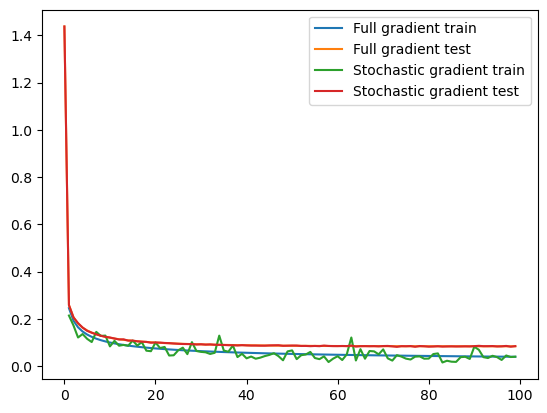

In [30]:
plt.plot([*range(len(cefList))],cefList)
plt.plot([*range(len(tcefList))],tcefList)
plt.plot([*range(len(cebList))],cebList)
plt.plot([*range(len(tcebList))],tcebList)
plt.legend(['Full gradient train','Full gradient test','Stochastic gradient train','Stochastic gradient test'])
plt.show()

Epoch:  0 , step:  0 , train loss:  None , test loss:  1.4377669906382167
Epoch:  0 , step:  1000 , train loss:  0.05929300613257667 , test loss:  0.2495689619062734
Epoch:  0 , step:  2000 , train loss:  0.029544603149000974 , test loss:  0.21697514160998915
Epoch:  1 , step:  3000 , train loss:  0.2006552812309665 , test loss:  0.17285371393951862
Epoch:  1 , step:  4000 , train loss:  1.551667121969771 , test loss:  0.21532491863513165
Epoch:  2 , step:  5000 , train loss:  0.031104213775585317 , test loss:  0.21259664502188694
Epoch:  2 , step:  6000 , train loss:  0.0023366874442115647 , test loss:  0.14426707018283394
Epoch:  3 , step:  7000 , train loss:  0.08443828367331692 , test loss:  0.1337075633271774
Epoch:  3 , step:  8000 , train loss:  0.457025488352349 , test loss:  0.14146754356287836
Epoch:  4 , step:  9000 , train loss:  0.007859021564127214 , test loss:  0.12040165305020238
Epoch:  4 , step:  10000 , train loss:  0.014411337974422558 , test loss:  0.12389738163167

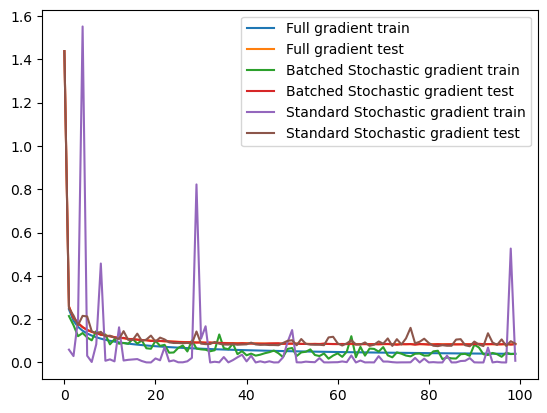

In [31]:
cesList, tcesList = logistic.batchedStochasticGradient([np.copy(w0),np.copy(b0)], [trainX,trainY], [testX,testY], 1, maxStep = 100000, printInterval = 1000)

plt.plot([*range(len(cefList))],cefList)
plt.plot([*range(len(tcefList))],tcefList)
plt.plot([*range(len(cebList))],cebList)
plt.plot([*range(len(tcebList))],tcebList)
plt.plot([*range(len(cesList))],cesList)
plt.plot([*range(len(tcesList))],tcesList)
plt.legend(['Full gradient train','Full gradient test','Batched Stochastic gradient train','Batched Stochastic gradient test','Standard Stochastic gradient train','Standard Stochastic gradient test'])
plt.show()